# Useful Functions

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from networks.cqa import CQA


def print_array_info(arr_list, name_list=None):
    if not isinstance(arr_list, (list, tuple)):
        arr_list = [arr_list]
    
    name_list = [i for i in range(len(arr_list))] if name_list is None else name_list
    for i in range(len(arr_list)):
        arr = arr_list[i]
        if hasattr(arr, 'min') and hasattr(arr, 'max') and hasattr(arr, 'shape'):
            min_val, max_val = arr.min(), arr.max()
            if hasattr(min_val, 'item'):
                min_val = min_val.item()
            if hasattr(max_val, 'item'):
                max_val = max_val.item()
            shape = tuple(arr.shape)
            print(f'ARR {name_list[i]} INFO: {shape}, [min,max]=[{min_val},{max_val}], range={max_val-min_val}.')
        else:
            print(f'ARR {name_list[i]} INFO: Not an array, type {type(arr)}.')


def true_round(value):
    """
    Perform rounding as taught in school, i.e., rounding to nearest integer 
    without considering it's odd or even.
    """
    return np.floor(value + 0.5).astype(int) if value >= 0 else np.ceil(value - 0.5).astype(int)


def show_multiple_images(
    images, 
    nrows=1, 
    ncols=None, 
    titles=None, 
    tight=True, 
    cmaps='gray', 
    figsize=None, 
    fontsize=12,
    dpi=None, 
    set_axis_off=True,
):

    num_imgs = len(images)
    ncols = true_round(num_imgs / nrows) if ncols is None else ncols
    num_plots = int(nrows * ncols)
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (tuple, list)) else cmaps
    titles = [titles] * num_imgs if not isinstance(titles, (tuple, list)) else titles
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i in range(num_imgs):
        if isinstance(images[i], torch.Tensor):
            img = images[i].cpu().squeeze()
        elif isinstance(images[i], np.ndarray):
            img = images[i].squeeze()
        elif isinstance(images[i], Image.Image):
            img = np.array(images[i]).squeeze()
        else:
            img = images[i]
        
        axes[i].imshow(img, cmap=cmaps[i])
        if set_axis_off:
            axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i], fontsize=fontsize)
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
            
    if tight:
        fig.tight_layout()


def normalize_hu(hu, min_hu=-1024, max_hu=3072, do_clip=True):
    if do_clip:
        hu = hu.clip(min_hu, max_hu) if hasattr(hu, 'clip') else min(max(hu, min_hu), max_hu)
    return (hu - min_hu) / (max_hu - min_hu)

def to_tensor(img: np.ndarray, device='cpu'):
    return normalize_hu(torch.from_numpy(img).float()).unsqueeze(0).unsqueeze(0).to(device)


# CQA Model Demo

## Pretrained Weights Loading

In [2]:
DEVICE = 'cuda'
net_kwargs = dict(in_channels=1, out_channels=10, attn_ratio=[0,1/2,1,0,0], use_spectrals=[True,True,True,False,False], use_rope=True, do_multiscale=True)
cqa_net = CQA(**net_kwargs)
ckpt_path = './configs/cqa_v1.pkl'  # Specify your path of pretrained CQA model weights
cqa_net.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
cqa_net = cqa_net.eval().to(DEVICE)

## CQA Inference

ARR 1070_ma_02.npy INFO: (512, 512), [min,max]=[-1304.6875,10539.0625], range=11843.75.
ARR 1070_gt.npy INFO: (512, 512), [min,max]=[-1000.0,1515.625], range=2515.625.
ARR DICOM-1-PA2-SE2-IM86_Titanium_d8_p10_n4_ma_02.npy INFO: (512, 512), [min,max]=[-3024,4095], range=7119.
ARR DICOM-1-PA2-SE2-IM86_p10_gt.npy INFO: (512, 512), [min,max]=[-3024,2224], range=5248.
ARR 0 INFO: (1, 1, 512, 512), [min,max]=[0.0,1.0], range=1.0.
ARR 1 INFO: (1, 1, 512, 512), [min,max]=[0.005859375,0.620025634765625], range=0.614166259765625.
ARR 2 INFO: (1, 1, 512, 512), [min,max]=[0.0,1.0], range=1.0.
ARR 3 INFO: (1, 1, 512, 512), [min,max]=[0.0,0.79296875], range=0.79296875.


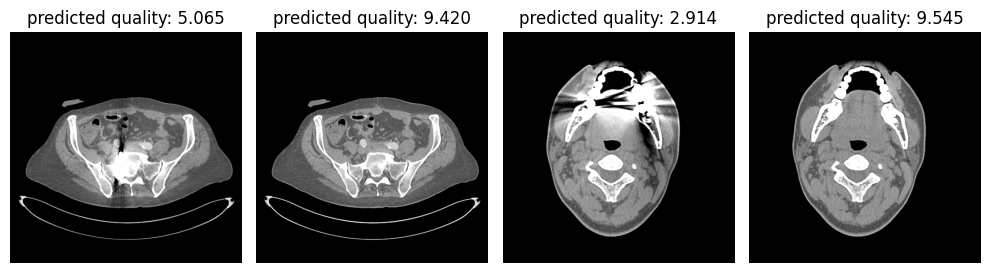

In [3]:
def logit2quality(logits: torch.Tensor):
    batch_size = logits.shape[0]
    num_classes = logits.shape[1]
    classes = F.softmax(logits, dim=-1)  # (batch_size, num_classes)
    refs = (torch.arange(1, num_classes+1)).repeat(batch_size, 1).float().to(classes.device)
    qualities = (classes * refs).sum(dim=-1, keepdim=True)  # (batch_size, 1)
    return qualities.squeeze()


image_paths = [
    './data/deeplesion/case1/1070_ma_02.npy',
    './data/deeplesion/case1/1070_gt.npy',
    './data/dental/case1/DICOM-1-PA2-SE2-IM86_Titanium_d8_p10_n4_ma_02.npy',
    './data/dental/case1/DICOM-1-PA2-SE2-IM86_p10_gt.npy',
]

images = [np.load(p) for p in image_paths]
print_array_info(images, name_list=[p.split('/')[-1] for p in image_paths])
tensors = [to_tensor(img, device=DEVICE) for img in images]
print_array_info(tensors)
qualities = []

with torch.no_grad():
    qualities = [logit2quality(cqa_net(x.to(DEVICE))) for x in tensors]

show_multiple_images(
    [img.clip(-300, 300) for img in images],  # smaller window for better visualization
    titles=[f"predicted quality: {q:.3f}" for q in qualities],
    figsize=(10, 3)
)

# MAR Model Demo

In [2]:
from networks.mar import RiseMARNet

DEVICE = 'cuda'
risemar_body = RiseMARNet(1, 1, base_channels=64)
ckpt_body_path = './configs/risemar_body_preview.pkl'
risemar_body.load_state_dict(torch.load(ckpt_body_path, map_location='cpu'))
risemar_body = risemar_body.eval().to(DEVICE)

risemar_dental = RiseMARNet(1, 1, base_channels=64)
ckpt_dental_path = './configs/risemar_dental_preview.pkl'
risemar_dental.load_state_dict(torch.load(ckpt_dental_path, map_location='cpu'))
risemar_dental = risemar_dental.eval().to(DEVICE)

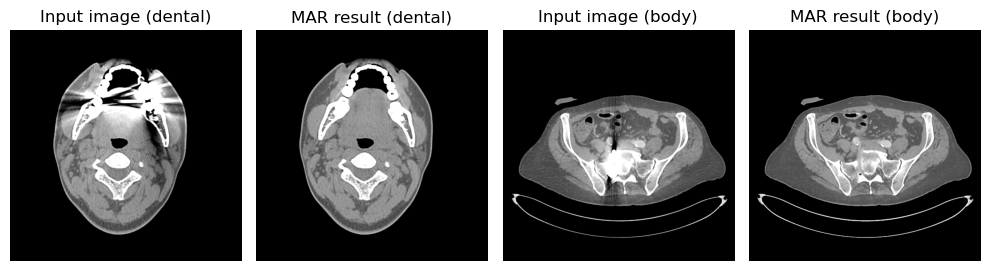

In [3]:
img_body_path = './data/deeplesion/case1/1070_ma_02.npy'
img_dental_path = './data/dental/case1/DICOM-1-PA2-SE2-IM86_Titanium_d8_p10_n4_ma_02.npy'

w0 = normalize_hu(-300) # min windowing HU
w1 = normalize_hu(300)  # max windowing HU

x_body = np.load(img_body_path)
x_body = to_tensor(x_body, device=DEVICE)
x_dental = np.load(img_dental_path)
x_dental = to_tensor(x_dental, device=DEVICE)

with torch.no_grad():
    y_body = risemar_body(x_body).cpu().clip(0, 1)
    y_dental = risemar_dental(x_dental).cpu().clip(0, 1)

show_multiple_images(
    [_.clip(w0, w1) for _ in [x_dental, y_dental, x_body, y_body]], 
    titles=['Input image (dental)', 'MAR result (dental)', 'Input image (body)', 'MAR result (body)'],
    figsize=(10, 3)
)